# Drop Out

In [1]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, losses, metrics

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import RMSprop

import numpy as np
import matplotlib.pyplot as plt
import PIL
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 데이터셋 디렉터리 경로
dataset_dir = '/content/drive/MyDrive/dataset_real'
# train_dir = os.path.join(dataset_dir, 'train')
# val_dir = os.path.join(dataset_dir, 'val')

# 사진 크기
image_height = 224
image_width = 224
batch_size = 32



train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)



# 훈련셋에서 배치를 생성
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

Found 1006 files belonging to 4 classes.
Using 805 files for training.
Found 1006 files belonging to 4 classes.
Using 201 files for validation.
(32, 224, 224, 3)
(32,)


# Model 1 (Original)

In [4]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

IMG_SHAPE = (image_height, image_width) + (3,)
base_model = VGG16(input_shape=IMG_SHAPE,
                   include_top=False,
                   weights='imagenet')



normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
feature_batch = base_model(image_batch)

base_model.trainable = False
base_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [5]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

In [6]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
# x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs, outputs)

In [7]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss = 'mse',
              metrics = ['mae'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 1)                 513   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [8]:
initial_epochs = 10

history = model.fit_generator(train_ds,
                              epochs=initial_epochs,
                              validation_data=val_ds)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/10
26/26 [==============================] - 211s 8s/step - loss: 9.3025 - mae: 2.4846 - val_loss: 6.2568 - val_mae: 2.0028
Epoch 2/10
26/26 [==============================] - 9s 311ms/step - loss: 7.0690 - mae: 2.0855 - val_loss: 5.1370 - val_mae: 1.8128
Epoch 3/10
26/26 [==============================] - 9s 319ms/step - loss: 6.1664 - mae: 1.8879 - val_loss: 4.6318 - val_mae: 1.7136
Epoch 4/10
26/26 [==============================] - 9s 317ms/step - loss: 5.6321 - mae: 1.7887 - val_loss: 4.2833 - val_mae: 1.6452
Epoch 5/10
26/26 [==============================] - 9s 313ms/step - loss: 5.1623 - mae: 1.7121 - val_loss: 3.9499 - val_mae: 1.5766
Epoch 6/10
26/26 [==============================] - 9s 314ms/step - loss: 4.7434 - mae: 1.6346 - val_loss: 3.6920 - val_mae: 1.5241
Epoch 7/10
26/26 [==============================] - 9s 313ms/step - loss: 4.3798 - mae: 1.5742 - val_loss: 3.4759 - val_mae: 1.4819
Epoch 8/10
26/26 [==============================] - 9s 314ms/step - loss: 4.0

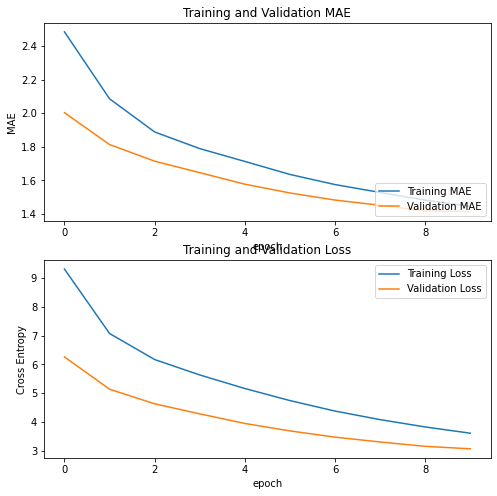

In [9]:
mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.show()

# Model 2 (Drop Out 0.5)

In [10]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

IMG_SHAPE = (image_height, image_width) + (3,)
base_model = VGG16(input_shape=IMG_SHAPE,
                   include_top=False,
                   weights='imagenet')



normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
feature_batch = base_model(image_batch)

base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

In [12]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs, outputs)

In [13]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss = 'mse',
              metrics = ['mae'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [14]:
initial_epochs = 10

history = model.fit_generator(train_ds,
                              epochs=initial_epochs,
                              validation_data=val_ds)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/10
26/26 [==============================] - 10s 324ms/step - loss: 21.2624 - mae: 3.6965 - val_loss: 7.5256 - val_mae: 2.2029
Epoch 2/10
26/26 [==============================] - 9s 312ms/step - loss: 18.6230 - mae: 3.3660 - val_loss: 6.2735 - val_mae: 1.9909
Epoch 3/10
26/26 [==============================] - 9s 315ms/step - loss: 16.0278 - mae: 3.0750 - val_loss: 5.5856 - val_mae: 1.8673
Epoch 4/10
26/26 [==============================] - 9s 319ms/step - loss: 16.0900 - mae: 3.1103 - val_loss: 5.2882 - val_mae: 1.8151
Epoch 5/10
26/26 [==============================] - 9s 315ms/step - loss: 15.4507 - mae: 3.1243 - val_loss: 5.0239 - val_mae: 1.7605
Epoch 6/10
26/26 [==============================] - 9s 343ms/step - loss: 13.9861 - mae: 2.9031 - val_loss: 4.8373 - val_mae: 1.7330
Epoch 7/10
26/26 [==============================] - 9s 314ms/step - loss: 14.1512 - mae: 2.9404 - val_loss: 4.6506 - val_mae: 1.6932
Epoch 8/10
26/26 [==============================] - 9s 314ms/step - 

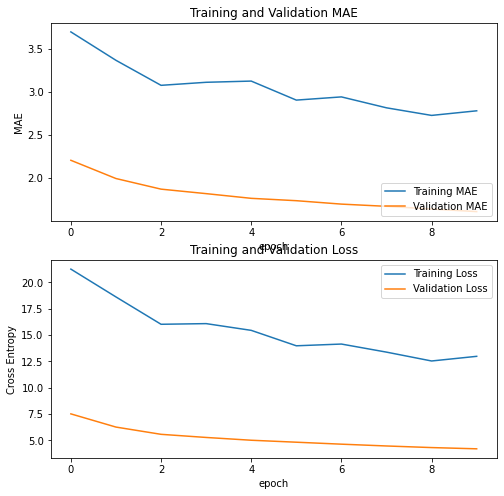

In [15]:
mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.show()

# Model 3 (Drop Out 0.7)

In [16]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

IMG_SHAPE = (image_height, image_width) + (3,)
base_model = VGG16(input_shape=IMG_SHAPE,
                   include_top=False,
                   weights='imagenet')



normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
feature_batch = base_model(image_batch)

base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

In [18]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = layers.Dropout(0.7)(x)
outputs = layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs, outputs)

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss = 'mse',
              metrics = ['mae'])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [20]:
initial_epochs = 10

history = model.fit_generator(train_ds,
                              epochs=initial_epochs,
                              validation_data=val_ds)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/10
26/26 [==============================] - 10s 323ms/step - loss: 47.7851 - mae: 5.3569 - val_loss: 8.5132 - val_mae: 2.2782
Epoch 2/10
26/26 [==============================] - 9s 314ms/step - loss: 38.8376 - mae: 4.7878 - val_loss: 6.3654 - val_mae: 1.9339
Epoch 3/10
26/26 [==============================] - 9s 312ms/step - loss: 37.1907 - mae: 4.6558 - val_loss: 5.1458 - val_mae: 1.7371
Epoch 4/10
26/26 [==============================] - 9s 313ms/step - loss: 35.9796 - mae: 4.6734 - val_loss: 4.5449 - val_mae: 1.6361
Epoch 5/10
26/26 [==============================] - 9s 314ms/step - loss: 32.9127 - mae: 4.4571 - val_loss: 4.2485 - val_mae: 1.5844
Epoch 6/10
26/26 [==============================] - 9s 315ms/step - loss: 32.7815 - mae: 4.3996 - val_loss: 4.0310 - val_mae: 1.5405
Epoch 7/10
26/26 [==============================] - 9s 321ms/step - loss: 33.9465 - mae: 4.5164 - val_loss: 3.8860 - val_mae: 1.5082
Epoch 8/10
26/26 [==============================] - 9s 314ms/step - 

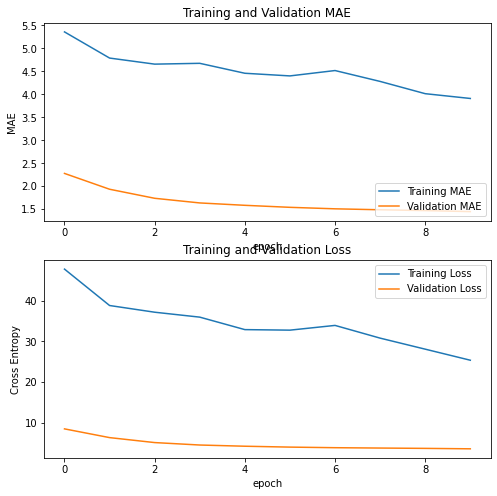

In [21]:
mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.show()

# Model 3 (Drop Out 0.9)

In [22]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

IMG_SHAPE = (image_height, image_width) + (3,)
base_model = VGG16(input_shape=IMG_SHAPE,
                   include_top=False,
                   weights='imagenet')



normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
feature_batch = base_model(image_batch)

base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [23]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

In [24]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = layers.Dropout(0.9)(x)
outputs = layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs, outputs)

In [25]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss = 'mse',
              metrics = ['mae'])

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [26]:
initial_epochs = 10

history = model.fit_generator(train_ds,
                              epochs=initial_epochs,
                              validation_data=val_ds)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/10
26/26 [==============================] - 10s 323ms/step - loss: 151.4787 - mae: 9.0634 - val_loss: 20.2389 - val_mae: 3.9867
Epoch 2/10
26/26 [==============================] - 9s 315ms/step - loss: 157.7596 - mae: 9.2475 - val_loss: 16.7448 - val_mae: 3.5780
Epoch 3/10
26/26 [==============================] - 9s 314ms/step - loss: 144.1182 - mae: 8.9897 - val_loss: 14.3776 - val_mae: 3.2747
Epoch 4/10
26/26 [==============================] - 9s 317ms/step - loss: 128.2277 - mae: 8.5983 - val_loss: 12.1711 - val_mae: 2.9761
Epoch 5/10
26/26 [==============================] - 9s 314ms/step - loss: 119.3259 - mae: 8.1415 - val_loss: 10.5155 - val_mae: 2.7331
Epoch 6/10
26/26 [==============================] - 9s 314ms/step - loss: 115.2655 - mae: 8.2357 - val_loss: 9.2043 - val_mae: 2.5229
Epoch 7/10
26/26 [==============================] - 9s 314ms/step - loss: 115.9190 - mae: 7.9823 - val_loss: 7.9414 - val_mae: 2.2981
Epoch 8/10
26/26 [==============================] - 9s 3

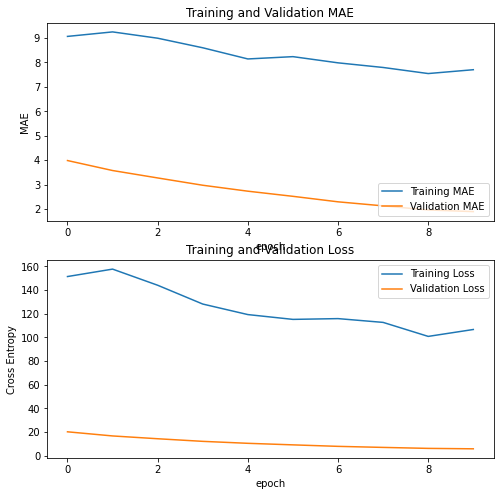

In [27]:
mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.show()